# Distiller – clustering of motif CIF/PDB files

The archive `motif_cif_files*.tar.zst` contains over 300 motif structures in
mmCIF and PDB formats. These files can be analyzed with `distiller` in order to
identify groups of nearly identical RNA structures and remove redundancy.

The aim of this notebook is to demonstrate how different operating modes and
parameters of `distiller` influence the clustering results. In particular, we
compare:

- the fast, feature-based clustering in `--mode approximate`,
- the rigorous, geometry-based clustering in `--mode exact`,
- the effect of parameters such as `--radius`, `--threshold`, and
  `--rmsd-method`.


In [5]:
!find ../data/motifs -type f \( -name "*.cif" -o -name "*.pdb" \) > ../outputs/motif_files.txt
!head ../outputs/motif_files.txt

../data/motifs/motif_cif_files/HL_1U6B_004.cif
../data/motifs/motif_cif_files/HL_1NBS_007.cif
../data/motifs/motif_cif_files/HL_5TPY_006.cif
../data/motifs/motif_cif_files/HL_5FJC_003.cif
../data/motifs/motif_cif_files/HL_9DFE_018.cif
../data/motifs/motif_cif_files/HL_9DFE_030.cif
../data/motifs/motif_cif_files/HL_8CRE_215.cif
../data/motifs/motif_cif_files/HL_6LAX_002.cif
../data/motifs/motif_cif_files/HL_4V9F_020.cif
../data/motifs/motif_cif_files/HL_3E5C_002.cif


### Run A – approximate mode with default parameters

This run uses the default configuration of the approximate mode.  
Clustering is performed using PCA-reduced features and FAISS, with the default
radius values (1, 2, 4, and 8). It provides a fast overview of redundancy levels
in the full dataset.

In [9]:
!distiller \
  --mode approximate \
  --output-json ../outputs/distiller_approx_default.json \
  - < ../outputs/motif_files.txt \
  > ../outputs/distiller_approx_default.txt

Featurizing: 100%|████████████████████| 315/315 [00:03<00:00, 103.84structure/s]


In [10]:
!head ../outputs/distiller_approx_default.txt

Processing 315 files
Parsing structure files...

Validating nucleotide counts...
All structures have 8 nucleotides

Running approximate mode (feature-based PCA + FAISS)
Feature matrix shape: (315, 952)
PCA reduced to 23 dimensions (95 % variance)



### Run B – approximate mode with custom radius values

In this run, only two radius values are used: a small one (1) and a large one
(8). This allows a direct comparison between conservative clustering and more
aggressive redundancy reduction.

In [11]:
!distiller \
  --mode approximate \
  --radius 1 \
  --radius 8 \
  --output-json ../outputs/distiller_approx_r1_r8.json \
  - < ../outputs/motif_files.txt \
  > ../outputs/distiller_approx_r1_r8.txt


Featurizing: 100%|████████████████████| 315/315 [00:03<00:00, 103.71structure/s]


In [12]:
!head ../outputs/distiller_approx_r1_r8.txt


Processing 315 files
Parsing structure files...

Validating nucleotide counts...
All structures have 8 nucleotides

Running approximate mode (feature-based PCA + FAISS)
Feature matrix shape: (315, 952)
PCA reduced to 23 dimensions (95 % variance)



### Analysis of approximate mode results

The approximate mode reports how many representatives are identified for
different values of the `--radius` parameter. This directly shows how strongly
the dataset is reduced by clustering.

Small radius values preserve almost all structures, while larger values merge
more motifs into fewer representatives, removing redundancy more aggressively.


In [10]:
import re

radii = []
representatives = []

with open("../outputs/distiller_approx_default.txt") as f:
    for line in f:
        m = re.search(r"Identified (\d+) representatives with radius ([0-9.]+)", line)
        if m:
            representatives.append(int(m.group(1)))
            radii.append(float(m.group(2)))


In [11]:
import pandas as pd

df = pd.DataFrame({
    "Radius": radii,
    "Number of representatives": representatives
})

df

,Radius,Number of representatives
0,1.0,315
1,2.0,315
2,4.0,279
3,8.0,122


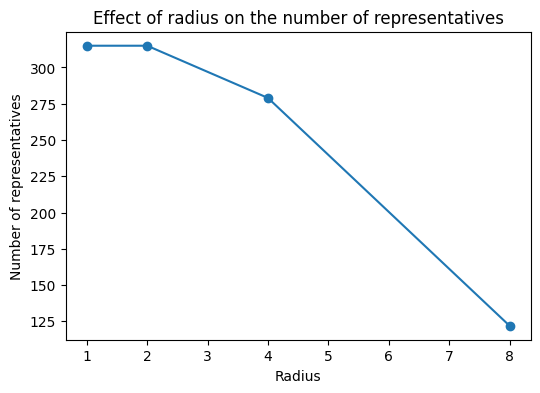

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(radii, representatives, marker="o")
plt.xlabel("Radius")
plt.ylabel("Number of representatives")
plt.title("Effect of radius on the number of representatives")
plt.show()


### Run C – exact mode on the full dataset (executed offline)

This run demonstrates the exact clustering mode applied to the full dataset of
motif structures. Because this mode is computationally expensive and may take
several minutes to complete, it was executed once offline.

In [16]:
# !distiller \
#   --mode exact \
#   --output-json ../outputs/distiller_exact_full.json \
#   - < ../outputs/motif_files.txt \
#   > ../outputs/distiller_exact_auto.txt

Computing nRMSD: 100%|██████████████████| 49020/49020 [11:09<00:00, 73.19pair/s]


In [18]:
!head ../outputs/distiller_exact_auto.txt

Processing 315 files
Parsing structure files...

Validating nucleotide counts...
All structures have 8 nucleotides

Initializing nRMSD cache...
Loaded 435 cached nRMSD values from nrmsd_cache.json

Computing distance matrix...


In [1]:
!tail ../outputs/distiller_exact_auto.txt

  Cluster 75: ../data/motifs/motif_cif_files/HL_4QLM_001.cif + 0 members
  Cluster 76: ../data/motifs/motif_cif_files/HL_3KTW_001.cif + 0 members
  Cluster 77: ../data/motifs/motif_cif_files/HL_3AGV_001.cif + 0 members
  Cluster 78: ../data/motifs/motif_cif_files/HL_6UFH_004.cif + 0 members
  Cluster 79: ../data/motifs/motif_cif_files/HL_4KQY_002.cif + 0 members
  Cluster 80: ../data/motifs/motif_cif_files/HL_7QR8_001.cif + 0 members
  Cluster 81: ../data/motifs/motif_cif_files/HL_5VSU_001.cif + 0 members
  Cluster 82: ../data/motifs/motif_cif_files/HL_1L9A_001.cif + 0 members

Comprehensive clustering results saved to ../outputs/distiller_exact_auto.json


In [7]:
log_file = "../outputs/distiller_exact_auto.txt"

with open(log_file) as f:
    lines = f.readlines()

In [8]:
import re

patterns = [
    r"auto.*threshold",
    r"final.*cluster",
    r"number of clusters",
    r"clusters found",
    r"input structures",
]

for line in lines:
    for p in patterns:
        if re.search(p, line.lower()):
            print(line.strip())
            break

Auto-detected optimal threshold: 0.058692
Number of clusters: 82


### Exact mode analisys

The exact mode automatically selected an optimal nRMSD threshold of **0.058692**,
which resulted in **82 clusters** for the full dataset.

The threshold is chosen from the point where the clustering curve changes most
rapidly, balancing between splitting structures too finely and merging
dissimilar ones. The number of clusters is then obtained by grouping all
structures whose pairwise nRMSD values are below this threshold.

This shows that the dataset contains strong redundancy and can be reduced to a
much smaller set of representative motif families.


<br><br>



The approximate mode is well suited for large datasets because it is fast and
allows efficient exploration of redundancy using different `--radius` values.

The exact mode provides a rigorous, geometry-based reference based on nRMSD
values, but it is computationally expensive. For this reason, it is shown here
using results that were generated offline on the full dataset.

Together, these runs show how `distiller` can be used in two complementary ways:
as a fast tool for large-scale redundancy detection and as a precise method for
high-quality structural clustering.